In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import Dropdown, interact, FloatSlider, IntSlider, RadioButtons, Text

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.covariance import EmpiricalCovariance
from time import localtime, timezone

from category_encoders import BinaryEncoder, OneHotEncoder, OrdinalEncoder

# Wrangle Function

In [2]:
def wrangle(filename):
    df = pd.read_csv(filename)
    
    # Drop Missing Values
    df = df.dropna()
    
    # Columns to drop
    cols_to_drop = []
    
    # Drop columns with multidimensionality
    cols_to_drop.append("Unnamed: 0")
    
    # Drop Outliers
    mask_Chol = df["Chol"] <= 500
    mask_Oldpeak = df["Oldpeak"] <= 5
    
    df = df[mask_Chol & mask_Oldpeak]
    
    # Drop ALL Above
    df = df.drop(columns=cols_to_drop).reset_index(drop=True)
    
    return df

In [3]:
# load data and view part of data
heart = wrangle("heart.csv")
print(heart.head())
heart.tail()

   Age  Sex     ChestPain  RestBP  Chol  Fbs  RestECG  MaxHR  ExAng  Oldpeak  \
0   63    1       typical     145   233    1        2    150      0      2.3   
1   67    1  asymptomatic     160   286    0        2    108      1      1.5   
2   67    1  asymptomatic     120   229    0        2    129      1      2.6   
3   37    1    nonanginal     130   250    0        0    187      0      3.5   
4   41    0    nontypical     130   204    0        2    172      0      1.4   

   Slope   Ca        Thal  AHD  
0      3  0.0       fixed   No  
1      2  3.0      normal  Yes  
2      2  2.0  reversable  Yes  
3      3  0.0      normal   No  
4      1  0.0      normal   No  


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
289,57,0,asymptomatic,140,241,0,0,123,1,0.2,2,0.0,reversable,Yes
290,45,1,typical,110,264,0,0,132,0,1.2,2,0.0,reversable,Yes
291,68,1,asymptomatic,144,193,1,0,141,0,3.4,2,2.0,reversable,Yes
292,57,1,asymptomatic,130,131,0,0,115,1,1.2,2,1.0,reversable,Yes
293,57,0,nontypical,130,236,0,2,174,0,0.0,2,1.0,normal,Yes


# Exploratory Data Analysis

In [4]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        294 non-null    int64  
 1   Sex        294 non-null    int64  
 2   ChestPain  294 non-null    object 
 3   RestBP     294 non-null    int64  
 4   Chol       294 non-null    int64  
 5   Fbs        294 non-null    int64  
 6   RestECG    294 non-null    int64  
 7   MaxHR      294 non-null    int64  
 8   ExAng      294 non-null    int64  
 9   Oldpeak    294 non-null    float64
 10  Slope      294 non-null    int64  
 11  Ca         294 non-null    float64
 12  Thal       294 non-null    object 
 13  AHD        294 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 32.3+ KB


In [5]:
heart["AHD"].value_counts(normalize=True)

No     0.540816
Yes    0.459184
Name: AHD, dtype: float64

In [6]:
heart.describe(include="all")

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
count,294.000000,294.000000,294,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294,294
unique,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2
top,NaN,NaN,asymptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,No
freq,NaN,NaN,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164,159
mean,54.472789,0.680272,NaN,131.625850,246.659864,0.146259,0.993197,149.710884,0.326531,1.020748,1.591837,0.673469,NaN,NaN
std,9.056004,0.467166,NaN,17.743224,48.599287,0.353968,0.994844,22.938293,0.469743,1.100331,0.609986,0.932268,NaN,NaN
min,29.000000,0.000000,NaN,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,NaN,NaN
25%,48.000000,0.000000,NaN,120.000000,211.250000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,NaN,NaN
50%,56.000000,1.000000,NaN,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,NaN,NaN
75%,61.000000,1.000000,NaN,140.000000,275.750000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,NaN,NaN


In [7]:
heart.shape

(294, 14)

In [8]:
heart.groupby(["ChestPain", "Thal", "AHD"]).mean()

Age       Sex      RestBP        Chol  \
ChestPain    Thal       AHD                                                
asymptomatic fixed      No   60.000000  1.000000  136.666667  207.000000   
                        Yes  55.888889  0.888889  137.888889  235.888889   
             normal     No   52.965517  0.379310  127.241379  255.034483   
                        Yes  59.875000  0.625000  129.500000  262.000000   
             reversable No   56.142857  1.000000  125.000000  221.571429   
                        Yes  55.338235  0.838235  134.602941  253.867647   
nonanginal   fixed      Yes  57.500000  1.000000  128.000000  237.000000   
             normal     No   51.722222  0.425926  128.814815  243.666667   
                        Yes  53.200000  1.000000  131.200000  228.600000   
             reversable No   56.200000  0.900000  129.900000  234.300000   
                        Yes  61.090909  0.909091  138.090909  244.090909   
nontypical   fixed      No   41.000000  1.000000  135.000000  203.000000   
                        Yes  66.000000  1.000000  160.000000  246.000000   
             normal     No   50.057143  0.542857  127.285714  241.571429   
                        Yes  57.500000  0.500000  135.000000  267.750000   
             reversable No   50.000000  1.000000  114.750000  247.500000   
                        Yes  55.250000  1.000000  136.500000  263.500000   
typical      fixed      No   57.500000  1.000000  131.500000  209.500000   
             normal     No   57.000000  0.555556  139.000000  230.222222   
                        Yes  61.000000  1.000000  141.500000  248.250000   
             reversable No   54.200000  1.000000  152.000000  237.400000   
                        Yes  47.333333  1.000000  133.333333  261.000000   

                                  Fbs   RestECG       MaxHR     ExAng  \
ChestPain    Thal       AHD                                             
asymptomatic fixed      No   0.000000  0.666667  137.333333  0.333333   
                        Yes  0.222222  1.444444  128.000000  0.555556   
             normal     No   0.000000  1.034483  156.620690  0.206897   
                        Yes  0.083333  1.375000  134.125000  0.625000   
             reversable No   0.142857  0.285714  141.857143  0.428571   
                        Yes  0.161765  1.132353  138.014706  0.691176   
nonanginal   fixed      Yes  1.000000  1.000000  138.000000  0.500000   
             normal     No   0.203704  0.833333  158.870370  0.092593   
                        Yes  0.000000  0.800000  147.600000  0.000000   
             reversable No   0.300000  0.600000  157.900000  0.200000   
                        Yes  0.090909  1.090909  143.272727  0.272727   
nontypical   fixed      No   0.000000  0.000000  132.000000  0.000000   
                        Yes  0.000000  0.000000  120.000000  1.000000   
             normal     No   0.085714  0.685714  166.285714  0.085714   
                        Yes  0.250000  2.000000  162.500000  0.000000   
             reversable No   0.250000  0.500000  162.000000  0.000000   
                        Yes  0.000000  1.000000  151.750000  0.000000   
typical      fixed      No   0.500000  2.000000  170.000000  0.000000   
             normal     No   0.222222  1.333333  150.000000  0.222222   
                        Yes  0.250000  1.000000  151.500000  0.000000   
             reversable No   0.200000  1.200000  163.600000  0.200000   
                        Yes  0.000000  0.666667  157.666667  0.333333   

                              Oldpeak     Slope        Ca  
ChestPain    Thal       AHD                                
asymptomatic fixed      No   1.400000  1.666667  0.000000  
                        Yes  2.011111  2.111111  1.444444  
             normal     No   0.596552  1.413793  0.172414  
                        Yes  1.216667  1.791667  1.208333  
             reversable No   0.171429  1.285714  0.571429  
                        Yes  1.689706

In [9]:
heart.groupby(["ChestPain", "Thal", "AHD"]).sum()

Age  Sex  RestBP   Chol  Fbs  RestECG  MaxHR  \
ChestPain    Thal       AHD                                                  
asymptomatic fixed      No    180    3     410    621    0        2    412   
                        Yes   503    8    1241   2123    2       13   1152   
             normal     No   1536   11    3690   7396    0       30   4542   
                        Yes  1437   15    3108   6288    2       33   3219   
             reversable No    393    7     875   1551    1        2    993   
                        Yes  3763   57    9153  17263   11       77   9385   
nonanginal   fixed      Yes   115    2     256    474    2        2    276   
             normal     No   2793   23    6956  13158   11       45   8579   
                        Yes   266    5     656   1143    0        4    738   
             reversable No    562    9    1299   2343    3        6   1579   
                        Yes   672   10    1519   2685    1       12   1576   
nontypical   fixed      No     41    1     135    203    0        0    132   
                        Yes    66    1     160    246    0        0    120   
             normal     No   1752   19    4455   8455    3       24   5820   
                        Yes   230    2     540   1071    1        8    650   
             reversable No    200    4     459    990    1        2    648   
                        Yes   221    4     546   1054    0        4    607   
typical      fixed      No    115    2     263    419    1        4    340   
             normal     No    513    5    1251   2072    2       12   1350   
                        Yes   244    4     566    993    1        4    606   
             reversable No    271    5     760   1187    1        6    818   
                        Yes   142    3     400    783    0        2    473   

                             ExAng  Oldpeak  Slope    Ca  
ChestPain    Thal       AHD                               
asymptomatic fixed      No       1      4.2      5   0.0  
                        Yes      5     18.1     19  13.0  
             normal     No       6     17.3     41   5.0  
                        Yes     15     29.2     43  29.0  
             reversable No       3      1.2      9   4.0  
                        Yes     47    114.9    123  80.0  
nonanginal   fixed      Yes      1      2.8      4   2.0  
             normal     No       5     31.5     77  15.0  
                        Yes      0      7.4      7   3.0  
             reversable No       2      7.1     15   6.0  
                        Yes      3     19.0     21  13.0  
nontypical   fixed      No       0      0.0      2   0.0  
                        Yes      1      0.0      2   3.0  
             normal     No       3     10.9     43   8.0  
                        Yes      0      1.8      6   4.0  
             reversable No       0      0.0      4   0.0  
                        Yes      0      2.7      7   2.0  
typical      fixed      No       0      2.3      5   0.0  
             normal     No       2     10.4     13   6.0  
                        Yes      0      4.8      6   5.0  
             reversable No       1      9.3     10   0.0  
                        Yes      1      5.2      6   0.0

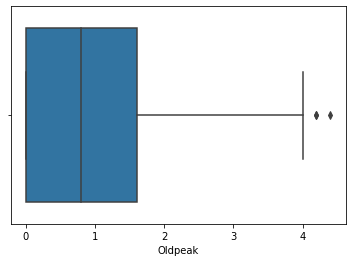

In [10]:
sns.boxplot(data=heart, x="Oldpeak");

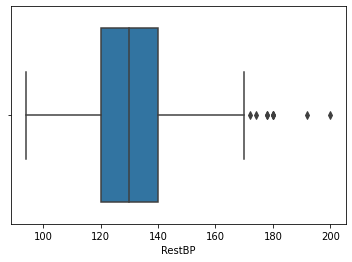

In [11]:
sns.boxplot(data=heart, x="RestBP");

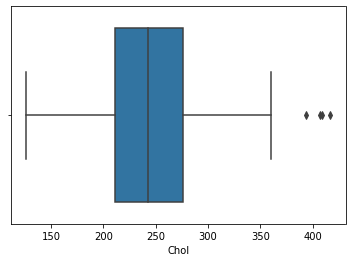

In [12]:
sns.boxplot(data=heart, x="Chol");

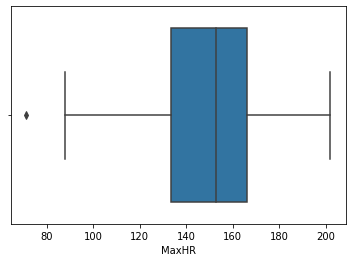

In [13]:
sns.boxplot(data=heart, x="MaxHR");

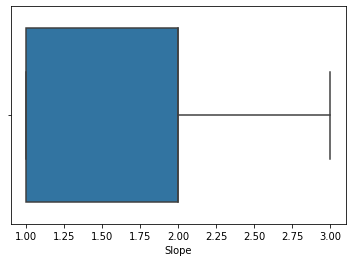

In [14]:
sns.boxplot(data=heart, x="Slope");

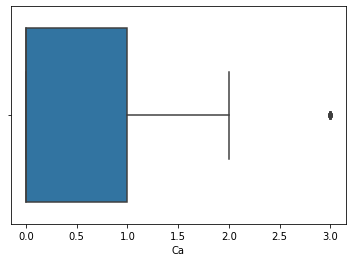

In [15]:
sns.boxplot(data=heart, x="Ca");

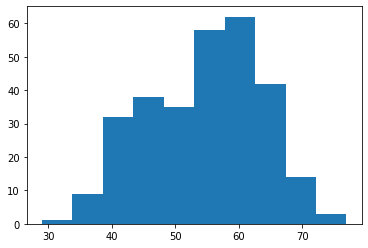

In [16]:
plt.hist(heart.Age);

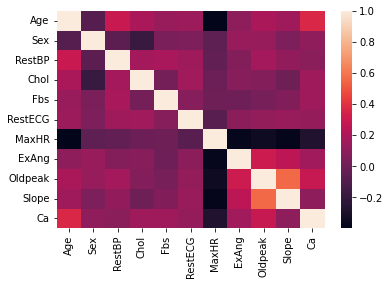

In [17]:
corr = heart.drop(columns=["AHD"]).corr()
sns.heatmap(corr);

# Build Baseline and Split Data

In [18]:
Acc_Baseline = heart["AHD"].value_counts(normalize=True)

print("The Baseline Accuracy Score = ", round(max(Acc_Baseline), 4))

The Baseline Accuracy Score =  0.5408


In [19]:
target = "AHD"
y = heart[target]
X = heart.drop(columns=target)

print(X.shape)
print(y.shape)


(294, 13)
(294,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)
print(X_train.shape)
print(y_train.shape)

(59, 13)
(59,)
(59, 13)
(59,)
(176, 13)
(176,)


# Build Logistic Regression Model

In [21]:
LogReg = make_pipeline(
    OneHotEncoder(),
    LogisticRegression(max_iter=3000)
)

In [22]:
LogReg.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['ChestPain', 'Thal'])),
                ('logisticregression', LogisticRegression(max_iter=3000))])

In [23]:
y_pred_train = LogReg.predict(X_train)
y_pred_val = LogReg.predict(X_val)

Acc_Train = accuracy_score(y_train, y_pred_train)
Acc_val = accuracy_score(y_val, y_pred_val)

print("The Accuracy score for Train = ", round(Acc_Train, 4), " and Validation data = ", round(Acc_val, 4))

The Accuracy score for Train =  0.9034  and Validation data =  0.8136


In [24]:
trained = pd.DataFrame({"y_train": y_train, "y_pred_train": y_pred_train}).reset_index(drop=True)
trained.head()

,y_train,y_pred_train
0,Yes,No
1,No,No
2,No,No
3,No,No
4,No,No


In [25]:
validated = pd.DataFrame({"y_val": y_val, "y_pred_val": y_pred_val}).reset_index(drop=True)
validated.head()

,y_val,y_pred_val
0,No,No
1,Yes,Yes
2,No,No
3,No,No
4,Yes,Yes


In [26]:
y_pred_test = LogReg.predict(X_test)
Acc_Test = accuracy_score(y_test, y_pred_test)

print("The Accuracy score for Test data = ", round(Acc_Test, 4))

The Accuracy score for Test data =  0.7966


In [27]:
test = pd.DataFrame({"y_test": y_test, "y_pred_test": y_pred_test}).reset_index(drop=True)
test.to_csv("heart prediction logistic regression.csv")
test.head()

,y_test,y_pred_test
0,No,Yes
1,No,No
2,No,No
3,No,No
4,No,No


In [28]:
test.value_counts()

y_test  y_pred_test
No      No             29
Yes     Yes            18
        No              9
No      Yes             3
dtype: int64

In [29]:
validated.value_counts()

y_val  y_pred_val
No     No            27
Yes    Yes           21
       No             6
No     Yes            5
dtype: int64

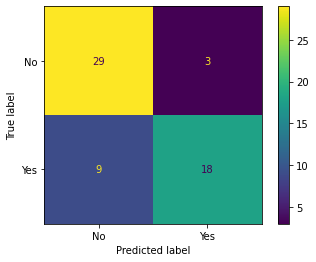

In [30]:
ConfusionMatrixDisplay.from_estimator(LogReg, X_test, y_test);

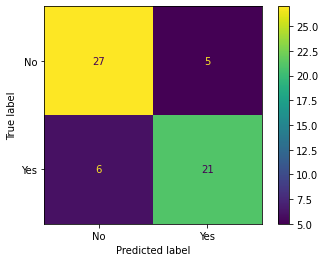

In [31]:
ConfusionMatrixDisplay.from_estimator(LogReg, X_val, y_val);

In [32]:
class_report = classification_report(y_test, y_pred_test, labels=["No","Yes"])
print("Classification Report: ", "\n", class_report)

Classification Report:  
               precision    recall  f1-score   support

          No       0.76      0.91      0.83        32
         Yes       0.86      0.67      0.75        27

    accuracy                           0.80        59
   macro avg       0.81      0.79      0.79        59
weighted avg       0.81      0.80      0.79        59



# Building a Decision Tree

In [33]:
depth_range = range(1, 10)
Acc_Train_tree = []
Acc_val_tree = []

for depth in depth_range:
    
    DecTree = make_pipeline(
        OneHotEncoder(),
        DecisionTreeClassifier(random_state=42, max_depth=depth)
    )
    DecTree.fit(X_train, y_train)
    y_pred_train_tree = DecTree.predict(X_train)
    y_pred_val_tree = DecTree.predict(X_val)

    Acc_Train_tree.append(accuracy_score(y_train, y_pred_train_tree))
    Acc_val_tree.append(accuracy_score(y_val, y_pred_val_tree))

#print("The Accuracy score of depth = ", depth, "for Train = ", round(Acc_Train_tree, 4), " and Validation data = ", round(Acc_val_tree, 4))

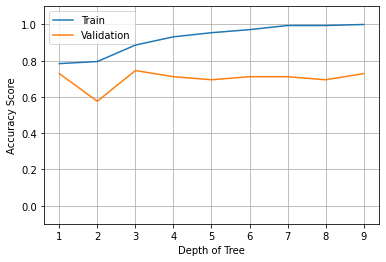

In [34]:
plt.plot(depth_range, Acc_Train_tree, label="Train")
plt.plot(depth_range, Acc_val_tree, label ="Validation")
plt.xlabel("Depth of Tree")
plt.ylabel("Accuracy Score")
plt.ylim(-0.1, 1.1)
plt.grid()
plt.legend();

In [35]:
DecTree_model = make_pipeline(
    OneHotEncoder(),
    DecisionTreeClassifier(random_state=42, max_depth=4)
)
DecTree_model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['ChestPain', 'Thal'])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=4, random_state=42))])

In [36]:
train_acc = accuracy_score(y_train, DecTree_model.predict(X_train))
val_acc = accuracy_score(y_val, DecTree_model.predict(X_val))
test_acc = accuracy_score(y_test, DecTree_model.predict(X_test))

In [37]:
print("The Accuracy score for Train data = ", round(train_acc, 4))
print("The Accuracy score for Validation data = ", round(val_acc, 4))
print("The Accuracy score for Test data = ", round(test_acc, 4))

The Accuracy score for Train data =  0.9318
The Accuracy score for Validation data =  0.7119
The Accuracy score for Test data =  0.7966


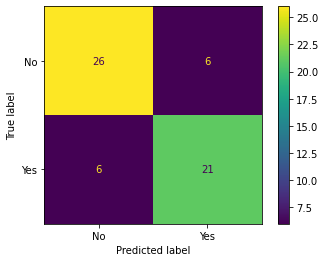

In [38]:
ConfusionMatrixDisplay.from_estimator(DecTree_model, X_test, y_test);

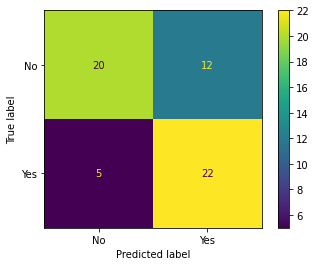

In [39]:
ConfusionMatrixDisplay.from_estimator(DecTree_model, X_val, y_val);

In [40]:
class_report_tree = classification_report(y_test, DecTree_model.predict(X_test), labels=["No","Yes"])
print("Classification Report for DT: ", "\n", class_report_tree)

Classification Report for DT:  
               precision    recall  f1-score   support

          No       0.81      0.81      0.81        32
         Yes       0.78      0.78      0.78        27

    accuracy                           0.80        59
   macro avg       0.80      0.80      0.80        59
weighted avg       0.80      0.80      0.80        59



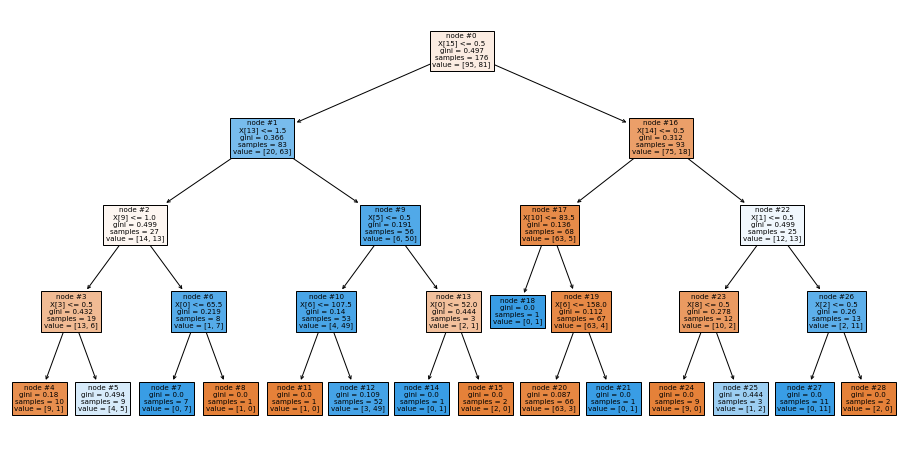

In [41]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_tree(
    DecTree_model.named_steps["decisiontreeclassifier"],
    filled=True,
    node_ids=True,
)
plt.savefig("tree.png");

# Building an Interactive Dashboard for the Logistic Regression Model

In [42]:
#Create function for the final logistic regression model
def make_LogReg_prediction(Age, Sex, ChestPain, RestBP, Chol, Fbs, RestECG, MaxHR, ExAng, Oldpeak, Slope, Ca, Thal):
    print("Interactive Dashboard for final Logistics Regression Model")
    data={
        'Age':Age,
        'Sex':Sex,
        'ChestPain':ChestPain,
        'RestBP':RestBP,
        'Chol':Chol,
        'Fbs':Fbs,
        'RestECG':RestECG,
        'MaxHR':MaxHR,
        'ExAng':ExAng,
        'Oldpeak':Oldpeak,
        'Slope':Slope,
        'Ca':Ca,
        'Thal':Thal        
    }
    
    df= pd.DataFrame(data, index=[0])
    prediction= LogReg.predict(df)[0]
    
    return print('The patient has heart disease? ', prediction)

In [44]:
interact(
    make_LogReg_prediction,
    Age = IntSlider(
            value= X_train["Age"].mean(),
            min = X_train["Age"].min(),
            max = X_train["Age"].max()
    ),
    Sex = RadioButtons(
            options = heart["Sex"].unique(),
    ),
    ChestPain = Dropdown(
            options = sorted(X_train["ChestPain"].unique())
    ),
    RestBP = IntSlider(
            value= X_train["RestBP"].mean(),
            min = X_train["RestBP"].min(),
            max = X_train["RestBP"].max()
    ),
    Chol = IntSlider(
            value= X_train["Chol"].mean(),
            min = X_train["Chol"].min(),
            max = X_train["Chol"].max()
    ),
    Fbs = IntSlider(
            value= X_train["Fbs"].mean(),
            min = X_train["Fbs"].min(),
            max = X_train["Fbs"].max()
    ),
    RestECG = IntSlider(
            value= X_train["RestECG"].mean(),
            min = X_train["RestECG"].min(),
            max = X_train["RestECG"].max()
    ),
    MaxHR = IntSlider(
            value= X_train["MaxHR"].mean(),
            min = X_train["MaxHR"].min(),
            max = X_train["MaxHR"].max()
    ),
    ExAng = IntSlider(
            value= X_train["ExAng"].mean(),
            min = X_train["ExAng"].min(),
            max = X_train["ExAng"].max()
    ),
    Oldpeak = FloatSlider(
            value= X_train["Oldpeak"].mean(),
            min = X_train["Oldpeak"].min(),
            max = X_train["Oldpeak"].max()
    ),
    Slope = IntSlider(
            value= X_train["Slope"].mean(),
            min = X_train["Slope"].min(),
            max = X_train["Slope"].max()
    ),
    Ca = FloatSlider(
            value= X_train["Ca"].mean(),
            min = X_train["Ca"].min(),
            max = X_train["Ca"].max()
    ),
    Thal = Dropdown(
            options = sorted(X_train["Thal"].unique())
    )
);

interactive(children=(IntSlider(value=54, description='Age', max=76, min=34), RadioButtons(description='Sex', …